In [1]:
import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [2]:
TRAIN_DATA_URL = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip'
VAL_DATA_URL = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip'
INPUT_SIZE = 150

In [3]:
train_data_dir = keras.utils.get_file(
    os.path.basename(TRAIN_DATA_URL),
    TRAIN_DATA_URL,
    cache_dir='./',
    cache_subdir='',
    extract=True
)
train_dir = os.path.join(os.path.splitext(train_data_dir)[0])


val_data_dir = keras.utils.get_file(
    os.path.basename(VAL_DATA_URL),
    VAL_DATA_URL,
    cache_dir='./',
    cache_subdir='',
    extract=True
)
val_dir = os.path.join(os.path.splitext(val_data_dir)[0])

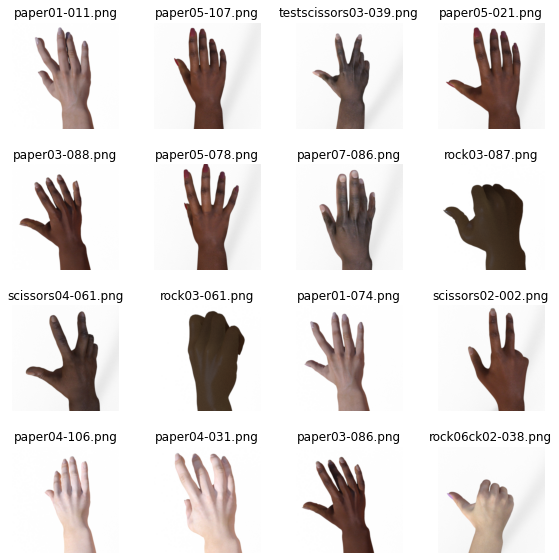

In [4]:
train_files = glob.glob(os.path.join(train_dir, '*/*.png'))
picked_files = random.choices(train_files, k=16)

fig = plt.figure(figsize=(8, 8))
for i, image_file in enumerate(picked_files, 1):
    ax = plt.subplot(4, 4, i)
    ax.imshow(load_img(image_file))
    ax.axis('off')
    ax.set_title(os.path.basename(image_file))

plt.tight_layout()
plt.show()

In [5]:
train_data = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'    
)
train_generator = train_data.flow_from_directory(
    train_dir,
    target_size=(INPUT_SIZE, INPUT_SIZE),
    batch_size=32,
    class_mode='categorical'
)

val_data = ImageDataGenerator(rescale=1.0/255)
val_generator = val_data.flow_from_directory(
    val_dir,
    target_size=(INPUT_SIZE, INPUT_SIZE),
    batch_size=32,
    class_mode='categorical'
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [6]:
print(f"class_indices = {train_generator.class_indices}")
index_to_class = dict((idx, class_name) for class_name, idx in train_generator.class_indices.items())
print(f"index_to_class = {index_to_class}")

class_indices = {'paper': 0, 'rock': 1, 'scissors': 2}
index_to_class = {0: 'paper', 1: 'rock', 2: 'scissors'}


In [7]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(INPUT_SIZE, INPUT_SIZE, 3)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [10]:
history = model.fit(
    train_generator, 
    epochs=25, 
    validation_data=val_generator, 
    verbose = 1,
)

Epoch 1/25
79/79 [==============================] - 22s 274ms/step - loss: 1.1781 - accuracy: 0.3516 - val_loss: 1.0463 - val_accuracy: 0.5726
Epoch 2/25
79/79 [==============================] - 21s 272ms/step - loss: 0.9657 - accuracy: 0.5405 - val_loss: 0.4617 - val_accuracy: 0.8038
Epoch 3/25
79/79 [==============================] - 21s 270ms/step - loss: 0.6313 - accuracy: 0.7389 - val_loss: 0.5752 - val_accuracy: 0.7231
Epoch 4/25
79/79 [==============================] - 21s 265ms/step - loss: 0.4504 - accuracy: 0.8218 - val_loss: 0.4946 - val_accuracy: 0.7608
Epoch 5/25
79/79 [==============================] - 21s 263ms/step - loss: 0.3480 - accuracy: 0.8655 - val_loss: 0.1452 - val_accuracy: 0.9597
Epoch 6/25
79/79 [==============================] - 21s 263ms/step - loss: 0.2643 - accuracy: 0.9036 - val_loss: 0.0771 - val_accuracy: 0.9731
Epoch 7/25
79/79 [==============================] - 20s 258ms/step - loss: 0.2097 - accuracy: 0.9230 - val_loss: 0.1355 - val_accuracy: 0.9516

In [11]:
def read_image_file(image_file):
    img = load_img(image_file, target_size=(INPUT_SIZE, INPUT_SIZE))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

def predict_file(image_file):
    img = read_image_file(image_file)
    classes = model.predict(img)
    print(f"file: {image_file}\nprediction: {index_to_class[np.argmax(classes)]}")

In [12]:
val_image_files = glob.glob(os.path.join(val_dir, '*/*.png'))

In [13]:
predict_file(val_image_files[0])

file: ./rps-test-set/rock/testrock02-19.png
prediction: rock


In [14]:
# from google.colab import files

# uploaded = files.upload()

# for file in uploaded.keys():
#     predict_file(file)